# SIR Modeling
SIR Modeling is a simple form of [compartmental modeling](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology). From the wikipedia page, 

> Compartmental models are a very general modelling technique. They are often applied to the mathematical modelling of infectious diseases. The population is assigned to compartments with labels – for example, S, I, or R, (Susceptible, Infectious, or Recovered). People may progress between compartments. The order of the labels usually shows the flow patterns between the compartments; for example SEIS means susceptible, exposed, infectious, then susceptible again. The models are most often run with ordinary differential equations (which are **deterministic**), but can also be used with a **stochastic** (random) framework, which is more realistic but much more complicated to analyze.

The three compartments are, 

* **S** - Susceptible individuals. Interactions with Infected result in individuals moving from S->I. 
* **I** - Infected individuals. Transitions from I->R due to either death or due to the disease running its course and taking the individual out of the S and I compartments.
* **R** - Recovered / Removed / Resistant

<br />

It is helpful to draw out diagrams of the different compartments in order to derive the differential equations (and initial conditions) governing SIR. Here is a link to a [Figma diagram]() to help us draw out our compartments. The resulting **initial-value problem** is as follows, 


<br />

$$
\begin{align}
\frac{\partial S}{\partial t} &= - \beta \cdot I \cdot S && S(0) = S_0 \\ \\
\frac{\partial I}{\partial t} &= \beta \cdot I \cdot S - \gamma \cdot I && I(0) = I_0 \\ \\ 
\frac{\partial R}{\partial t} &=  \gamma \cdot I && R(0) = R_0 \\ \\ 
\end{align}
$$

<br />

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

### % Population

In [2]:
I_0 = 0.001
S_0 = 1 - I_0
R_0 = 0

N = I_0 + S_0 + R_0
assert N == 1

### Interpreting time & coefficients
<br />

| Variable         | Description                                                                                   |
|:-----------------|:----------------------------------------------------------------------------------------------|
| "t" or "time"    | Non-specific (e.g. hours, days, years, etc). We associate this with simulation steps.         |
| disease_duration | The number of simulation steps (e.g. "time") an individual is infected.                       |
| $\gamma$         | Coefficient for rate of recovery which is inversely proportional to `disease_duration`        | 
| num_contacts     | Avg number of contacts (with other people) per person per time                                |
| prob_trans       | Probability of transmission between susceptible and infected persons                          |
| $\beta$          | Coefficient for rate of transmission which is proportional to `num_contacts` and `prob_trans` | 
| $R_0$            | basic reproduction number (speed of reproduction)                                             |


<br />

### $R_0$
https://en.wikipedia.org/wiki/Basic_reproduction_number

The most important uses of $R_0$ are determining if an emerging infectious disease can spread in a population and determining what proportion of the population should be immunized through vaccination to eradicate a disease. 

In commonly used infection models, when $R_0 > 1$ the infection will be able to start spreading in a population, but not if $R_0 < 1$. Generally, the larger the value of $R_0$, the harder it is to control the epidemic. 
<br />

In [12]:
disease_duration = 14

r_0 = 9.5

gamma = 1 / disease_duration

# num_contacts = 15
# prob_trans = 0.03
# beta = num_contacts * prob_trans
beta = r_0 * gamma

### Model Definition

In [13]:
days = 100

In [14]:
def SIR():
    
    ## define time domain
    t = np.linspace(0, days, days)
    dt = t[1] - t[0]
    
    ## define initial conditions
    S = np.zeros(days)
    S[0] = S_0

    I = np.zeros(days)
    I[0] = I_0
    
    R = np.zeros(days)
    R[0] = R_0

    
    for n in range(0, days - 1):
        
        ## calculate derivatives
        dI = beta * I[n] * S[n] - gamma * I[n]
        dS = -beta * I[n] * S [n]
        dR = gamma * I[n]
        
        ## calculate step forward
        S[n+1] = S[n] + (dS * dt)
        I[n+1] = I[n] + (dI * dt)
        R[n+1] = R[n] + (dR * dt)
        
    return pd.DataFrame({
        'susceptible': S, 
        'infected': I, 
        'recovered': R, 
        'days': t
    })

In [15]:
df = SIR()

In [16]:
df.head()

,susceptible,infected,recovered,days
0,0.999000,0.001000,0.000000,0.000000
1,0.998315,0.001613,0.000072,1.010101
2,0.997212,0.002600,0.000188,2.020202
3,0.995435,0.004189,0.000376,3.030303
4,0.992577,0.006745,0.000678,4.040404


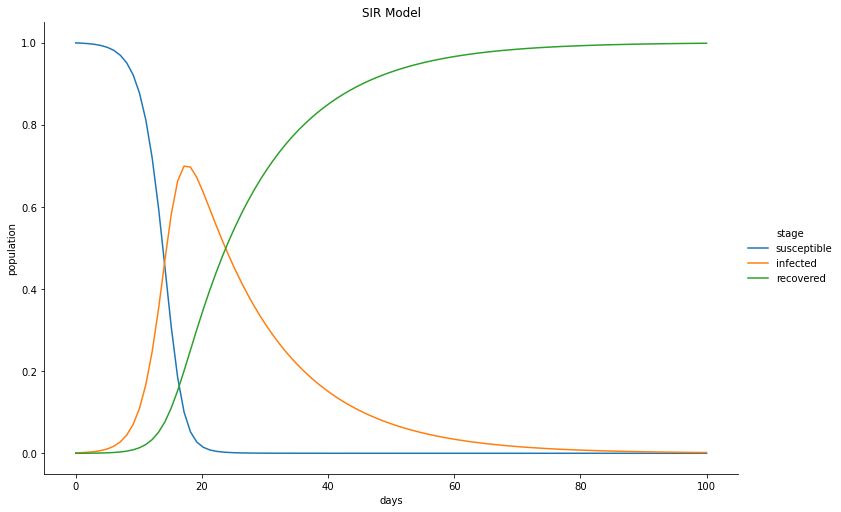

In [17]:
line = sns.relplot(
    data=pd.melt(df, id_vars=['days'], value_name='population', var_name='stage'),
    x='days',
    y='population',
    hue='stage',
    kind='line',
    height=7,
    aspect=1.5
).set(
    title="SIR Model"
)

# SIR Modeling for different values of $\beta$ while holding $\gamma$

In [18]:
r_0 = 9.5 # omicron variant of covid-19
beta = r_0 * gamma
beta

0.6785714285714285

In [20]:
betas = np.linspace(beta, 0.1, 5)
betas

array([0.67857143, 0.53392857, 0.38928571, 0.24464286, 0.1       ])

In [21]:
dfs = []
for beta in betas:
    beta = beta
    df = SIR()
    dfs.append(df)

In [22]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [26]:
# for idx, df in enumerate(dfs):
#     line = sns.relplot(
#         data=pd.melt(df, id_vars=['days'], value_name='population', var_name='stage'),
#         x='days',
#         y='population',
#         hue='stage',
#         kind='line',
#         height=7,
#         aspect=1.5
#     ).set(
#         title=f"SIR Model (beta={betas[idx]:0.2f}, r_0={r_0:0.2f}, gamma={gamma:0.2f})"
#     )

# SIRD Model
This is an expansion on the basic SIR Model that differentiates between _Recovered_ (immune) and _Deceased_. 

<br />

$$
\begin{align}
\frac{\partial S}{\partial t} &= - \beta \cdot I \cdot S && S(0) = S_0 \\ \\
\frac{\partial I}{\partial t} &= \beta \cdot I \cdot S - \gamma \cdot I - \mu \cdot I && I(0) = I_0 \\ \\ 
\frac{\partial R}{\partial t} &=  \gamma \cdot I && R(0) = R_0 \\ \\ 
\frac{\partial D}{\partial t} &=  \mu \cdot I && D(0) = D_0 \\ \\ 
\end{align}
$$

<br />

In [25]:
disease_duration = 14

r_0 = 9.5

gamma = 1 / disease_duration

# num_contacts = 15
# prob_trans = 0.03
# beta = num_contacts * prob_trans
beta = r_0 * gamma

In [27]:
days = 100

In [78]:
D_0 = 0.01
mu = 0.03

In [79]:
def SIRD():
    
    ## define time domain
    t = np.linspace(0, days, days)
    dt = t[1] - t[0]
    
    ## define initial conditions
    S = np.zeros(days)
    S[0] = S_0

    I = np.zeros(days)
    I[0] = I_0
    
    R = np.zeros(days)
    R[0] = R_0
    
    D = np.zeros(days)
    D[0] = D_0

    
    for n in range(0, days - 1):
        
        ## calculate derivatives
        dI = beta * I[n] * S[n] - gamma * I[n] - mu * D[n]
        dS = -beta * I[n] * S [n]
        dR = gamma * I[n]
        dD = mu * D[n]
        
        ## calculate step forward
        S[n+1] = S[n] + (dS * dt)
        I[n+1] = I[n] + (dI * dt)
        R[n+1] = R[n] + (dR * dt)
        D[n+1] = D[n] + (dD * dt)
        
    return pd.DataFrame({
        'susceptible': S, 
        'infected': I, 
        'recovered': R, 
        'deceased': D,
        'days': t
    })

In [80]:
df = SIRD()

In [81]:
df.head()

,susceptible,infected,recovered,deceased,days
0,0.999000,0.001000,0.000000,0.010000,0.000000
1,0.998315,0.001310,0.000072,0.010303,1.010101
2,0.997419,0.001799,0.000167,0.010615,2.020202
3,0.996189,0.002577,0.000296,0.010937,3.030303
4,0.994429,0.003820,0.000482,0.011268,4.040404


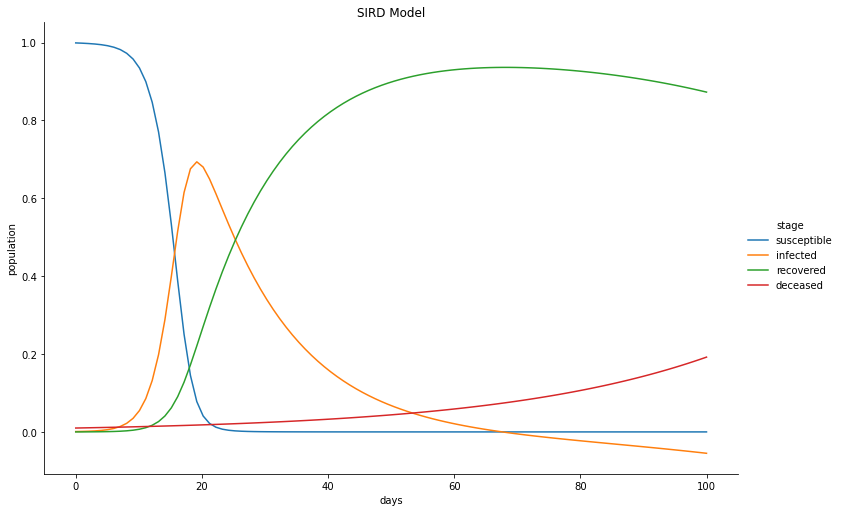

In [82]:
line = sns.relplot(
    data=pd.melt(df, id_vars=['days'], value_name='population', var_name='stage'),
    x='days',
    y='population',
    hue='stage',
    kind='line',
    height=7,
    aspect=1.5
).set(
    title="SIRD Model"
)

# SIRV Model
Another expansion on basic SIR, this includes _Vaccinations_.

<br />

$$
\begin{align}
\frac{\partial S}{\partial t} &= - \beta \cdot I \cdot S - v(t) \cdot S && S(0) = S_0 \\ \\
\frac{\partial I}{\partial t} &= \beta \cdot I \cdot S - \gamma \cdot I && I(0) = I_0 \\ \\ 
\frac{\partial R}{\partial t} &=  \gamma \cdot I && R(0) = R_0 \\ \\ 
\frac{\partial V}{\partial t} &=  v(t) \cdot S && V(0) = V_0 \\ \\ 
\end{align}
$$

<br />